<link rel='stylesheet' href='../assets/css/main.css'/>

[<< back to main index](../README.md)

# Logistic Regression in Spark  - Credit Card Approval (Demo)

### Overview
Instructor to demo this on screen.
 
### Builds on
None

### Run time
approx. 20-30 minutes

### Notes

Spark has a logistic regression function called Logistic Regression.

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Sigmoid Curve

Let's generate a sigmoid curve in python!

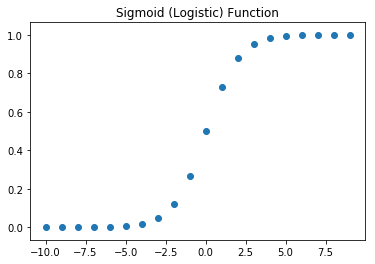

In [24]:
import numpy as np
# plot sigmoid curve
x = np.arange(-10.,10.,1.)
b = 0 # intercept
m = 1 # slope
sigmoid = lambda x,b,m: np.exp((b + m*x)) / (1 + np.exp((b + m*x)))
y = sigmoid(x,b,m)
plt.scatter(x,y)
plt.title("Sigmoid (Logistic) Function")


## Step 1: Credit Approval Data

Here is the sample data we are looking at:

| score | approved | 
|-------|----------| 
| 550   | 0        | 
| 750   | 1        | 
| 680   | 1        | 
| 650   | 0        | 
| 450   | 0        | 
| 800   | 1        | 
| 775   | 1        | 
| 525   | 0        | 
| 620   | 0        | 
| 705   | 0        | 
| 830   | 1        | 
| 610   | 1        | 
| 690   | 0        | 


## Step 2: Let's visualize the data

In [27]:
mydata = pd.DataFrame({'score' : [550., 750., 680., 650., 450., 800., 775., 525., 620., 705., 830., 610., 690.],
              'approved' : [0,1,1,0,0,1,1,0,0,0,1,1,0]
             })

mydata



,approved,score
0,0,550.0
1,1,750.0
2,1,680.0
3,0,650.0
4,0,450.0
5,1,800.0
6,1,775.0
7,0,525.0
8,0,620.0
9,0,705.0


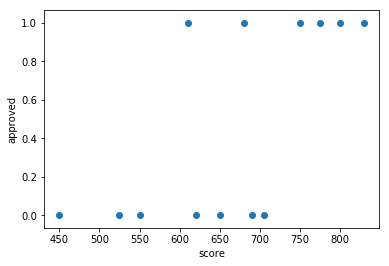

In [29]:
plt.scatter(mydata.score,mydata.approved)
plt.xlabel('score')
plt.ylabel('approved')

## Step 3: Convert dataframe to Spark and Prepare feature vector

We need to firstconvert the dataframe to spark, and then prepare the feature vector.




## Step 3: Run logistic regression

In [ ]:



mylogit = glm( approved ~ score, data=mydata, family="binomial")

# calculate some data
mydata$prob = predict (mylogit, newdata=mydata, type = "response")
print(mydata)

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)


The output lists approval & estimated probabilities

In [ ]:
   score    approved        prob
1    550        0       0.056627207
2    750        1       0.803539879
3    680        1       0.482763979
4    650        0       0.331324127
5    450        0       0.007219373
6    800        1       0.921575779
7    775        1       0.873940664
8    525        0       0.034202204
9    620        0       0.208262068
10   705        0       0.612710719
11   830        1       0.956776400
12   610        1       0.175590878
13   690        0       0.535466724

## Step 4: Visualize data and logit model

In [ ]:
# plot regression against data
sorted.data = mydata [order(mydata$score), ]
View(sorted.data)
print(sorted.data)
# plot data
plot(sorted.data$score, sorted.data$approved)
# plot logistic regression
lines(sorted.data$score, sorted.data$prob, col="red")  


<img src="../assets/images/logistic-regression-graph1.png" style="border: 5px solid grey ; max-width:100%;" />


Using 'popbio' package

In [ ]:
# another plot
# install.packages("pobio")
library(popbio)
logi.hist.plot(mydata$score, mydata$approved, boxp=FALSE)

<img src="../assets/images/logistic-regression-graph2.png" style="border: 5px solid grey ; max-width:100%;" />

## Step 5: Predict Credit Approvals for new data

We are going to calculate the credit approval possibility for scores of 600, 700 and 810.

In [ ]:
# predict approval for new scores
newdata = data.frame(score= c(600,700,810))
newdata$prob = predict(mylogit, newdata=newdata, type = "response")
View(newdata)
print(newdata)

Output

In [ ]:
  score      prob
1   600     0.1470928
2   700     0.5873891
3   810     0.9355370

So we can see
- credit score 600 has only 14% (probability 0.14) chance of getting approved
- credit score of 810 has 93% chance of approval